# Oscillation Models Evaluator

Compare multiple RheoJAX oscillation models on polystyrene mastercurve data.

**Data:** examples/data/pyRheo/polystyrene/master_curve_ps_oscillation_data.csv

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-07 17:21:06,304:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load oscillation dataset (polystyrene mastercurve)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Evaluate multiple models

In [4]:
models = {
    'GM-4': GeneralizedMaxwell(n_modes=4, modulus_type='tensile'),
    'GM-6': GeneralizedMaxwell(n_modes=6, modulus_type='tensile'),
    'FracMax': FractionalMaxwellModel(),
}
results = []
for name, model in models.items():
    try:
        model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
        pred = model.predict(omega)
        if pred.ndim == 2:
            pred = pred[:,0] + 1j*pred[:,1]
        r2 = r2_complex(G_star, pred)
        results.append({'model': name, 'r2': r2})
    except Exception as exc:
        results.append({'model': name, 'r2': np.nan, 'error': str(exc)})

pd.DataFrame(results)


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.336381s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.057424e+11 | time=1.336s | final_gradient_norm=67696131.21140718


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.313625s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.057424e+11 | time=0.314s | final_gradient_norm=67696131.21140718


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.683409s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=73 | final_cost=3.547676e+11 | time=0.683s | final_gradient_norm=3.130545506864798e+18


Element minimization: early termination at n_modes=3 (R²=0.993698 < threshold=0.997182)


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.146598s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=1.147s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.447586s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.448s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.115181s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=1.115s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.193602s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=1.194s | final_gradient_norm=0.0065040219009454515


,model,r2
0,GM-4,0.998121
1,GM-6,0.999666
2,FracMax,-43733.637158


## Plot best-fit overlay

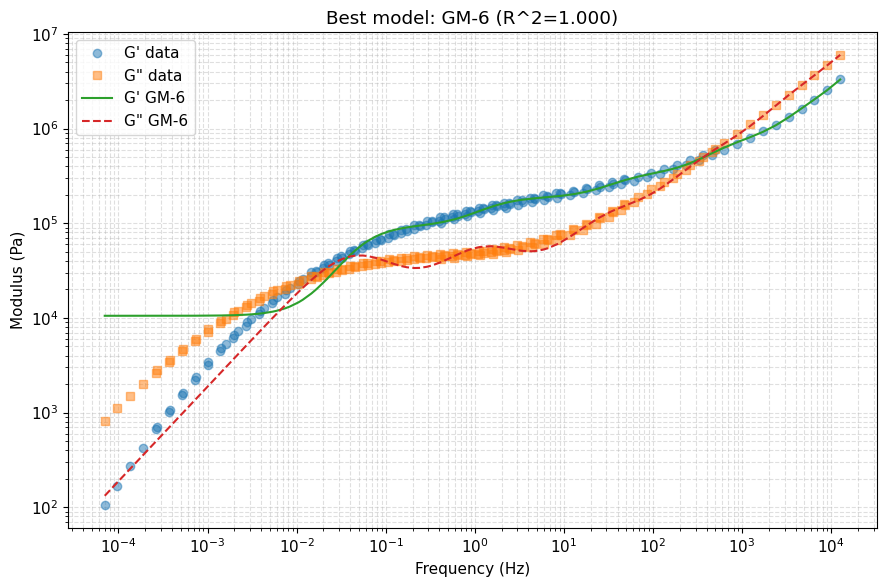

In [5]:
best_candidates = [r for r in results if np.isfinite(r.get('r2', np.nan))]
if not best_candidates:
    print('No successful models')
else:
    best = max(best_candidates, key=lambda x: x['r2'])
    best_model = models[best['model']]
    best_pred = best_model.predict(omega)
    if hasattr(best_pred, 'ndim') and best_pred.ndim == 2:
        best_pred = best_pred[:,0] + 1j*best_pred[:,1]
    freq_hz = omega/(2*np.pi)

    fig, ax = plt.subplots(figsize=(9,6))
    ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
    ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
    ax.loglog(freq_hz, np.real(best_pred), '-', label=f"G' {best['model']}")
    ax.loglog(freq_hz, np.imag(best_pred), '--', label=f'G" {best["model"]}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Modulus (Pa)')
    ax.set_title(f"Best model: {best['model']} (R^2={best['r2']:.3f})")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.332893s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=0.333s | final_gradient_norm=0.0065040219009454515


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.437979s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.438s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.442490s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.442s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.368571s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=0.369s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Model ranking (R²): [('best_model', 1.0), ('model', -43733.637)]


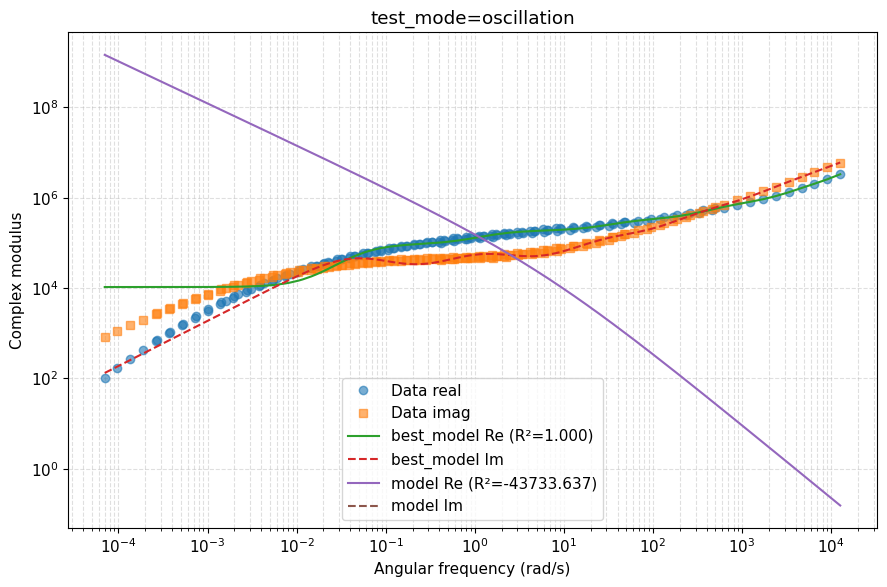

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:01<1:08:49,  1.03s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 30/4000 [00:01<01:51, 35.62it/s, 639 steps of size 8.31e-03. acc. prob=0.71]

warmup:   1%|          | 47/4000 [00:01<01:12, 54.53it/s, 1023 steps of size 5.46e-03. acc. prob=0.73]

warmup:   2%|▏         | 63/4000 [00:01<00:56, 70.08it/s, 1023 steps of size 7.40e-03. acc. prob=0.75]

warmup:   2%|▏         | 78/4000 [00:01<00:47, 82.63it/s, 1023 steps of size 6.56e-03. acc. prob=0.75]

warmup:   2%|▏         | 96/4000 [00:01<00:38, 102.48it/s, 287 steps of size 6.69e-03. acc. prob=0.76]

warmup:   4%|▍         | 157/4000 [00:01<00:17, 218.22it/s, 31 steps of size 2.81e-01. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:01<00:09, 402.11it/s, 63 steps of size 5.75e-02. acc. prob=0.78]

warmup:   8%|▊         | 334/4000 [00:01<00:07, 505.08it/s, 15 steps of size 6.97e-02. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [00:01<00:05, 646.94it/s, 63 steps of size 1.65e-01. acc. prob=0.79]

warmup:  14%|█▎        | 544/4000 [00:02<00:04, 760.54it/s, 31 steps of size 1.98e-01. acc. prob=0.79]

warmup:  17%|█▋        | 667/4000 [00:02<00:03, 892.42it/s, 15 steps of size 3.08e-01. acc. prob=0.79]

warmup:  20%|█▉        | 788/4000 [00:02<00:03, 982.57it/s, 63 steps of size 1.16e-01. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [00:02<00:02, 1038.50it/s, 31 steps of size 2.12e-01. acc. prob=0.79]

sample:  26%|██▌       | 1020/4000 [00:02<00:02, 1067.76it/s, 15 steps of size 1.67e-01. acc. prob=0.88]

sample:  28%|██▊       | 1139/4000 [00:02<00:02, 1103.18it/s, 31 steps of size 1.67e-01. acc. prob=0.89]

sample:  31%|███▏      | 1256/4000 [00:02<00:02, 1121.68it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  34%|███▍      | 1370/4000 [00:02<00:02, 1121.68it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  37%|███▋      | 1484/4000 [00:02<00:02, 1126.73it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  40%|████      | 1600/4000 [00:03<00:02, 1135.22it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  43%|████▎     | 1718/4000 [00:03<00:01, 1146.79it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  46%|████▌     | 1833/4000 [00:03<00:01, 1091.18it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  49%|████▊     | 1944/4000 [00:03<00:01, 1096.56it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2061/4000 [00:03<00:01, 1115.87it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  54%|█████▍    | 2175/4000 [00:03<00:01, 1120.90it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  57%|█████▋    | 2293/4000 [00:03<00:01, 1137.69it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  60%|██████    | 2408/4000 [00:03<00:01, 1127.61it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  63%|██████▎   | 2529/4000 [00:03<00:01, 1151.40it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  66%|██████▌   | 2645/4000 [00:03<00:01, 1152.63it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  69%|██████▉   | 2761/4000 [00:04<00:01, 1150.47it/s, 7 steps of size 1.67e-01. acc. prob=0.90] 

sample:  72%|███████▏  | 2878/4000 [00:04<00:00, 1155.91it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  75%|███████▍  | 2994/4000 [00:04<00:00, 1147.74it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  78%|███████▊  | 3110/4000 [00:04<00:00, 1149.46it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  81%|████████  | 3227/4000 [00:04<00:00, 1153.42it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  84%|████████▎ | 3343/4000 [00:04<00:00, 1149.35it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  86%|████████▋ | 3458/4000 [00:04<00:00, 1137.44it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  89%|████████▉ | 3572/4000 [00:04<00:00, 1134.29it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  92%|█████████▏| 3689/4000 [00:04<00:00, 1144.18it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  95%|█████████▌| 3806/4000 [00:04<00:00, 1149.88it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  98%|█████████▊| 3925/4000 [00:05<00:00, 1160.06it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 783.43it/s, 31 steps of size 1.67e-01. acc. prob=0.90] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 24/4000 [00:00<00:17, 222.07it/s, 1023 steps of size 8.02e-03. acc. prob=0.70]

warmup:   1%|          | 47/4000 [00:00<00:30, 131.01it/s, 383 steps of size 1.58e-02. acc. prob=0.74] 

warmup:   2%|▏         | 63/4000 [00:00<00:29, 135.12it/s, 1023 steps of size 8.86e-03. acc. prob=0.75]

warmup:   2%|▏         | 81/4000 [00:00<00:26, 145.26it/s, 511 steps of size 1.27e-02. acc. prob=0.76] 

warmup:   2%|▏         | 97/4000 [00:00<00:26, 144.84it/s, 5 steps of size 4.89e-03. acc. prob=0.76]  

warmup:   3%|▎         | 139/4000 [00:00<00:17, 225.00it/s, 31 steps of size 9.69e-02. acc. prob=0.77]

warmup:   6%|▌         | 245/4000 [00:00<00:07, 470.44it/s, 15 steps of size 1.10e-01. acc. prob=0.78]

warmup:   8%|▊         | 340/4000 [00:00<00:05, 611.82it/s, 15 steps of size 8.44e-02. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [00:01<00:04, 759.61it/s, 15 steps of size 2.06e+00. acc. prob=0.79]

warmup:  14%|█▍        | 550/4000 [00:01<00:04, 824.43it/s, 63 steps of size 1.25e-01. acc. prob=0.79]

warmup:  16%|█▋        | 659/4000 [00:01<00:03, 902.85it/s, 15 steps of size 3.41e-01. acc. prob=0.79]

warmup:  20%|█▉        | 784/4000 [00:01<00:03, 1005.16it/s, 15 steps of size 2.39e-01. acc. prob=0.79]

warmup:  23%|██▎       | 909/4000 [00:01<00:02, 1076.07it/s, 15 steps of size 2.01e-01. acc. prob=0.79]

sample:  25%|██▌       | 1018/4000 [00:01<00:02, 1067.58it/s, 15 steps of size 1.53e-01. acc. prob=0.95]

sample:  28%|██▊       | 1129/4000 [00:01<00:02, 1079.68it/s, 15 steps of size 1.53e-01. acc. prob=0.87]

sample:  31%|███       | 1238/4000 [00:01<00:02, 1068.23it/s, 31 steps of size 1.53e-01. acc. prob=0.90]

sample:  34%|███▎      | 1346/4000 [00:01<00:02, 1057.77it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample:  36%|███▋      | 1453/4000 [00:01<00:02, 1054.27it/s, 23 steps of size 1.53e-01. acc. prob=0.91]

sample:  39%|███▉      | 1559/4000 [00:02<00:02, 1050.10it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample:  42%|████▏     | 1665/4000 [00:02<00:02, 1042.30it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  44%|████▍     | 1770/4000 [00:02<00:02, 1043.37it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  47%|████▋     | 1875/4000 [00:02<00:02, 1041.19it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  50%|████▉     | 1983/4000 [00:02<00:01, 1050.72it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2091/4000 [00:02<00:01, 1056.94it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  55%|█████▍    | 2199/4000 [00:02<00:01, 1061.85it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  58%|█████▊    | 2306/4000 [00:02<00:01, 1056.60it/s, 15 steps of size 1.53e-01. acc. prob=0.92]

sample:  60%|██████    | 2413/4000 [00:02<00:01, 1059.51it/s, 7 steps of size 1.53e-01. acc. prob=0.92] 

sample:  63%|██████▎   | 2519/4000 [00:03<00:01, 1052.34it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  66%|██████▌   | 2628/4000 [00:03<00:01, 1061.72it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  68%|██████▊   | 2738/4000 [00:03<00:01, 1072.37it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  71%|███████   | 2846/4000 [00:03<00:01, 1067.88it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  74%|███████▍  | 2954/4000 [00:03<00:00, 1068.22it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  77%|███████▋  | 3062/4000 [00:03<00:00, 1070.45it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  79%|███████▉  | 3170/4000 [00:03<00:00, 1008.69it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  82%|████████▏ | 3278/4000 [00:03<00:00, 1028.70it/s, 31 steps of size 1.53e-01. acc. prob=0.90]

sample:  85%|████████▍ | 3382/4000 [00:03<00:00, 1026.71it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  87%|████████▋ | 3493/4000 [00:03<00:00, 1048.49it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  90%|████████▉ | 3599/4000 [00:04<00:00, 1046.15it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  93%|█████████▎| 3706/4000 [00:04<00:00, 1051.29it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  95%|█████████▌| 3815/4000 [00:04<00:00, 1059.10it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  98%|█████████▊| 3922/4000 [00:04<00:00, 1056.75it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 906.86it/s, 31 steps of size 1.53e-01. acc. prob=0.91] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 30/4000 [00:00<00:14, 272.09it/s, 1023 steps of size 8.14e-03. acc. prob=0.71]

warmup:   1%|▏         | 58/4000 [00:00<00:28, 140.34it/s, 511 steps of size 5.81e-03. acc. prob=0.74] 

warmup:   2%|▏         | 76/4000 [00:00<00:29, 131.33it/s, 1023 steps of size 5.80e-03. acc. prob=0.75]

warmup:   2%|▏         | 91/4000 [00:00<00:32, 119.20it/s, 1023 steps of size 7.86e-03. acc. prob=0.76]

warmup:   3%|▎         | 130/4000 [00:00<00:20, 186.16it/s, 15 steps of size 1.94e-01. acc. prob=0.77] 

warmup:   6%|▌         | 225/4000 [00:00<00:09, 385.20it/s, 31 steps of size 1.76e-01. acc. prob=0.78]

warmup:   8%|▊         | 339/4000 [00:00<00:06, 588.92it/s, 31 steps of size 1.72e-01. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [00:01<00:04, 762.14it/s, 4 steps of size 3.88e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 556/4000 [00:01<00:04, 816.84it/s, 31 steps of size 1.97e-01. acc. prob=0.79]

warmup:  16%|█▌        | 645/4000 [00:01<00:04, 830.16it/s, 31 steps of size 1.11e-01. acc. prob=0.79]

warmup:  19%|█▉        | 767/4000 [00:01<00:03, 942.77it/s, 15 steps of size 2.74e-01. acc. prob=0.79]

warmup:  22%|██▏       | 891/4000 [00:01<00:03, 1028.06it/s, 15 steps of size 1.96e-01. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [00:01<00:02, 1045.04it/s, 55 steps of size 1.34e-01. acc. prob=0.81]

sample:  28%|██▊       | 1108/4000 [00:01<00:02, 1049.39it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  30%|███       | 1215/4000 [00:01<00:02, 1050.82it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  33%|███▎      | 1322/4000 [00:01<00:02, 1009.27it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  36%|███▌      | 1425/4000 [00:02<00:02, 1015.04it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  38%|███▊      | 1528/4000 [00:02<00:02, 1012.70it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  41%|████      | 1633/4000 [00:02<00:02, 1023.12it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  43%|████▎     | 1738/4000 [00:02<00:02, 1029.58it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  46%|████▌     | 1846/4000 [00:02<00:02, 1042.81it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  49%|████▉     | 1953/4000 [00:02<00:01, 1048.92it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  51%|█████▏    | 2059/4000 [00:02<00:01, 1040.34it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  54%|█████▍    | 2164/4000 [00:02<00:01, 1040.51it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  57%|█████▋    | 2271/4000 [00:02<00:01, 1046.86it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  59%|█████▉    | 2376/4000 [00:02<00:01, 1044.11it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  62%|██████▏   | 2482/4000 [00:03<00:01, 1048.10it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  65%|██████▍   | 2589/4000 [00:03<00:01, 1052.83it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  67%|██████▋   | 2695/4000 [00:03<00:01, 1045.72it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  70%|███████   | 2800/4000 [00:03<00:01, 1042.07it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  73%|███████▎  | 2905/4000 [00:03<00:01, 1038.37it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  75%|███████▌  | 3011/4000 [00:03<00:00, 1043.03it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  78%|███████▊  | 3118/4000 [00:03<00:00, 1050.58it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  81%|████████  | 3224/4000 [00:03<00:00, 1044.63it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  83%|████████▎ | 3329/4000 [00:03<00:00, 1033.64it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  86%|████████▌ | 3434/4000 [00:03<00:00, 1035.73it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  88%|████████▊ | 3538/4000 [00:04<00:00, 1025.95it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  91%|█████████ | 3644/4000 [00:04<00:00, 1035.80it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  94%|█████████▎| 3748/4000 [00:04<00:00, 1036.33it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  96%|█████████▋| 3855/4000 [00:04<00:00, 1045.83it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  99%|█████████▉| 3962/4000 [00:04<00:00, 1050.69it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 891.86it/s, 31 steps of size 1.34e-01. acc. prob=0.94] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 37/4000 [00:00<00:11, 358.44it/s, 511 steps of size 2.01e-02. acc. prob=0.74]

warmup:   2%|▏         | 73/4000 [00:00<00:22, 172.47it/s, 895 steps of size 8.24e-03. acc. prob=0.75]

warmup:   2%|▏         | 96/4000 [00:00<00:21, 181.44it/s, 511 steps of size 1.02e-02. acc. prob=0.76]

warmup:   3%|▎         | 138/4000 [00:00<00:15, 248.46it/s, 31 steps of size 3.28e-01. acc. prob=0.78]

warmup:   5%|▌         | 214/4000 [00:00<00:09, 394.55it/s, 31 steps of size 1.02e-01. acc. prob=0.78]

warmup:   8%|▊         | 330/4000 [00:00<00:05, 616.30it/s, 15 steps of size 4.85e-01. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [00:00<00:04, 801.79it/s, 63 steps of size 1.22e-01. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [00:01<00:03, 871.70it/s, 31 steps of size 1.90e-01. acc. prob=0.79]

warmup:  17%|█▋        | 687/4000 [00:01<00:03, 990.96it/s, 31 steps of size 1.44e-01. acc. prob=0.79]

warmup:  20%|██        | 802/4000 [00:01<00:03, 1036.36it/s, 15 steps of size 1.36e-01. acc. prob=0.79]

warmup:  23%|██▎       | 934/4000 [00:01<00:02, 1119.64it/s, 15 steps of size 2.30e-01. acc. prob=0.79]

sample:  26%|██▌       | 1049/4000 [00:01<00:02, 1071.56it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  29%|██▉       | 1159/4000 [00:01<00:02, 1068.18it/s, 15 steps of size 1.56e-01. acc. prob=0.95]

sample:  32%|███▏      | 1268/4000 [00:01<00:02, 1064.79it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  34%|███▍      | 1376/4000 [00:01<00:02, 1066.33it/s, 7 steps of size 1.56e-01. acc. prob=0.94] 

sample:  37%|███▋      | 1484/4000 [00:01<00:02, 1061.34it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  40%|███▉      | 1591/4000 [00:01<00:02, 1061.38it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  42%|████▏     | 1698/4000 [00:02<00:02, 1060.40it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  45%|████▌     | 1805/4000 [00:02<00:02, 1045.69it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  48%|████▊     | 1910/4000 [00:02<00:02, 1037.87it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  50%|█████     | 2019/4000 [00:02<00:01, 1052.67it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  53%|█████▎    | 2125/4000 [00:02<00:01, 1038.10it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  56%|█████▌    | 2229/4000 [00:02<00:01, 1024.59it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  58%|█████▊    | 2333/4000 [00:02<00:01, 1028.65it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  61%|██████    | 2443/4000 [00:02<00:01, 1048.68it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [00:02<00:01, 1044.04it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  66%|██████▋   | 2653/4000 [00:02<00:01, 1040.68it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  69%|██████▉   | 2758/4000 [00:03<00:01, 1043.39it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  72%|███████▏  | 2865/4000 [00:03<00:01, 1050.65it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  74%|███████▍  | 2972/4000 [00:03<00:00, 1053.42it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  77%|███████▋  | 3078/4000 [00:03<00:00, 1042.82it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  80%|███████▉  | 3185/4000 [00:03<00:00, 1048.46it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  82%|████████▏ | 3291/4000 [00:03<00:00, 1051.29it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  85%|████████▍ | 3397/4000 [00:03<00:00, 1032.83it/s, 63 steps of size 1.56e-01. acc. prob=0.94]

sample:  88%|████████▊ | 3502/4000 [00:03<00:00, 1034.72it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  90%|█████████ | 3608/4000 [00:03<00:00, 1041.47it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  93%|█████████▎| 3715/4000 [00:03<00:00, 1048.51it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  96%|█████████▌| 3823/4000 [00:04<00:00, 1057.17it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  98%|█████████▊| 3929/4000 [00:04<00:00, 1051.03it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 941.62it/s, 31 steps of size 1.56e-01. acc. prob=0.94] 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='sigma_real'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_6'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigm

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_6\n0'}>,
        <Axes: title={'center': 'E_6\n1'}>,
        <Axes: title={'cent

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_6'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, 

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_6'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
